## Import libs and custom vars

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from libs.utils import find_penalty, return_outcome, check_element, add_labels, find_range
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import datetime
from numba import jit
import pycountry_convert as pc


<b>L'obbiettivo del progetto è la costruzione di un modello per predizioni di match internazionali</b>


<ul>
    <li>Ci sono alcuni nomi di squadre che sono cambiate nel tempo, uniformizza </li>
    <li>Shootouts è il db dei penalty, quindi bisogna manipolare il dataset per vedere chi vince alla fine quella partita</li>
</ul>

### Descrizione del dataset


Il Dataset contiene 42483 risultati di partite di calcio internazionale maschile. In particolare, sono incluse sia le partite ufficiali di tutte le competizioni: dalle amichevoli alla coppa del mondo eccetto i Giochi Olimpici o le partite dove almeno una delle due squadre era la squadra B o U-23. Inoltre, il dataset presenta un ulteriore file che contiene 432 risultati di partite terminate con i calci di rigore, <u>che non considereremo in quanto il modello dovrà predirre il risultato come: 'Home win', 'Draw', 'Away win'.</u>

In [2]:
dst_df = pd.read_csv('dataset/results.csv');

print("Null values:", dst_df.isnull().values.any(), "| shape:", dst_df.shape)
print("***"*15)
print(dst_df.info())

Null values: False | shape: (42483, 9)
*********************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42483 entries, 0 to 42482
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        42483 non-null  object
 1   home_team   42483 non-null  object
 2   away_team   42483 non-null  object
 3   home_score  42483 non-null  int64 
 4   away_score  42483 non-null  int64 
 5   tournament  42483 non-null  object
 6   city        42483 non-null  object
 7   country     42483 non-null  object
 8   neutral     42483 non-null  bool  
dtypes: bool(1), int64(2), object(6)
memory usage: 2.6+ MB
None


### Preparazione del daset
- campo date formattato in anno
- colonna 'risultato'
- converto home_score e away_score in float

In [3]:
dst_df = dst_df.astype({"home_score": float, "away_score": float})

dst_df['outcome'] = None
dst_df['day'] = None
dst_df['month'] = None
dst_df['year'] = None

date_separator = ', '

counter = 0
for i in range(0, len(dst_df)):
    counter = counter + 1
    print('*** Processing %d/%d ***' % (counter, len(dst_df)), end='\r')

    # Formatto i nomi dei continenti per standardizzarli al dataset FIFA usato dopo
    if(dst_df.loc[i]['country'] == 'United States'):
        dst_df.at[i, 'country'] = 'USA'

    # estraggo dati necessari dalla data
    row_date = datetime.date.fromisoformat(dst_df.iloc[i]['date'])
    dst_df.at[i, 'day'] = row_date.strftime('%d') + date_separator + row_date.strftime('%A')
    dst_df.at[i, 'month'] = row_date.strftime('%B')
    dst_df.at[i, 'year'] = int(row_date.strftime('%Y'))

    # calcolo il risultato della partita
    dst_df.at[i, 'outcome'] = return_outcome(dst_df.iloc[i]['home_score'], dst_df.iloc[i]['away_score'])

    # deprecato
    # if(dst_df.iloc[i]['outcome'] == 'D'):
    #     dst_df.at[i, 'outcome'] = find_penalty(data['results'].iloc[i], data['shootouts'], sht_len - 1)

dst_df.drop(labels=['date'], axis=1, inplace=True)
dst_df.to_csv('dataset/dataset.csv')

### To do:
1. <s>Statistica descrittiva</s> DOING
2. PMF sui dati degli anni / approssimaziona a CMF (?)
3. Barplot su:
    - goal fatti
    - sul numero di partite per continente
4. Scatterplot
    - sui goal ?
    - dei risultati di outcome D/H/A (?)

Da vedere come inserire:
- comparare il numero di partite per nazione
- score per games?

Modelli:
    - Regressione logistica
    - Alberi decisionali
    - o...?

Da inserire (?)
    - FIFa ranking per elaborazione modello
        - regole del ranking
        - spiegare funzionamento
        - aggiungere 'ranking' in base alla data
    
Aggiuntivi da implementare via facendo + descrizione
- Eliminare i paesi che hanno cambiato nome/pulizia dataset
- Riduzione delle dimensionalità
    - per il calcolo del modello considera solo se le partite sono state giocate in campo neutrale

In [7]:
dst = pd.read_csv('dataset/dataset.csv')
dst.drop(labels=['Unnamed: 0', 'city'], axis=1, inplace=True)

dst.head()

,home_team,away_team,home_score,away_score,tournament,country,neutral,outcome,day,month,year
0,Scotland,England,0.0,0.0,Friendly,Scotland,False,Draw,"30, Saturday",November,1872
1,England,Scotland,4.0,2.0,Friendly,England,False,Home,"08, Saturday",March,1873
2,Scotland,England,2.0,1.0,Friendly,Scotland,False,Home,"07, Saturday",March,1874
3,England,Scotland,2.0,2.0,Friendly,England,False,Draw,"06, Saturday",March,1875
4,Scotland,England,3.0,0.0,Friendly,Scotland,False,Home,"04, Saturday",March,1876


### 1. Statistica descrittiva - Distribuzione dei dati

Descrizione del dataset
1. Numero di partie per anno
2. Numero di partie per anno per contiente
3. Numero di goal per anno (? / scatterplot)
4. Numero di vittorie (scatterplot)


##### Numero di partite per anno:

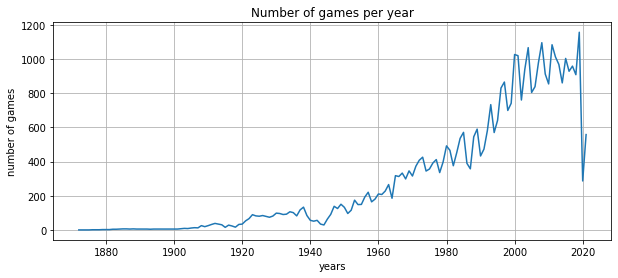

In [5]:
#### inserire prima guerra mondiale, seconda e covid

mpy = dst['year'].value_counts().sort_index()

plt.figure(figsize=(10,4))
plt.title(label='Number of games per year')
plt.ylabel(ylabel='number of games')
plt.xlabel(xlabel='years')
plt.plot(mpy)

plt.grid()
plt.show()

##### Numero di partite giocate per anno da ogni continente

In [8]:
# continente in cui è stato disputato il match
dst['continent'] = ''

# mi ricavo le confederazioni delle nazionali dal dataset FIFA
dst_fifa = pd.read_csv('dataset/fifa_ranking-2021-05-27.csv')
dst_fifa.drop(labels=['rank', 'rank_date', 'rank_change', 'total_points', 'previous_points', 'id'], axis=1, inplace=True)
dst_fifa.drop_duplicates(subset="country_full", keep="first", inplace=True)

# so già a prescindere che ci saranno delle nazioni non riconosciute
df_nocontinent_found = pd.DataFrame(columns=dst.columns)

index_mismatches_dst = []

for i in range(0, len(dst)):
    if( dst_fifa[(dst_fifa.country_full == dst.iloc[i]['country'])]['confederation'].values.__len__() == 1 ):
        confederation = dst_fifa[(dst_fifa.country_full == dst.iloc[i]['country'])]['confederation'].values[0]
        
        if confederation == "UEFA":
            continent = "Europe"

        if(confederation == "AFC"):
            continent = "Asia"
        
        if(confederation == "CAF"):
            continent = "Africa"

        if(confederation == "OFC"):
            continent = "Oceania"

        if confederation in "CONCACAF":
            continent = "America"

        if confederation in "CONMEBOL":
            continent = "America"

        dst.at[i, 'continent'] = continent
    else:
        df_nocontinent_found = df_nocontinent_found.append(dst.iloc[i])

# salvo per evitare di doverlo ricreare se faccio errori
dst.to_csv("dataset/dataset_continent.csv")
# per analizzare meglio salvo il csv
df_nocontinent_found.to_csv('output.csv')

In [ ]:
df_nocontinent_found.info()

Converto i le country con quelle aggiornate

In [ ]:
df_nocontinent_found.index, type(df_nocontinent_found.index)

In [ ]:
df_nocontinent_found = pd.read_csv('output.csv')
dst = pd.read_csv('dataset/dataset_continent.csv')
# risalvalo alla fine quando tutto va bene come dataset normale anche nella cella sopra! oppure elimina proprio il save

In [ ]:
for i in df_nocontinent_found.index:
    print(dst.iloc[i])
    if (dst.iloc[i]['country'] == 'Bohemia' or 'Soviet Union' or 'Irish Free State'):
        dst.at[i, 'continent'] = 'Europe'

    if (dst.iloc[i]['contruy'] == 'British Guyana' or 'Netherlands Guyana' or 'French Guiana' or 'Saint Kitts and Nevis' or 'Éire'):
        dst.at[i, 'continent'] = 'America'

    if (dst.iloc[i]['country'] == 'Manchuria'):
        dst.at[i, 'continent'] = 'Asia'

        #### sono arrivato ad ispezionare l'index 2346


        break


Controllo i le nazioni non trovate, in quanto so già da prima che vi sono nazioni che hanno cambiato nome SCRIVI BENE

In [29]:
df_nocontinent_found.value_counts('country')

Series([], dtype: int64)

Vi sono delle incorenze da sistemare nel dataset delle partite sulle città in quanto sono stati

In [8]:
dst_nan = dst[dst.isna().any(axis=1)]
dst_nan.to_csv('output2.csv')
dst_nan.head()

,home_team,away_team,home_score,away_score,tournament,country,neutral,outcome,day,month,year,confederation
41,USA,Canada,0.0,1.0,Friendly,United States,False,Away,"28, Saturday",November,1885,None
48,USA,Canada,3.0,2.0,Friendly,United States,False,Home,"25, Thursday",November,1886,None
189,Czechoslovakia,Hungary,4.0,4.0,Friendly,Bohemia,False,Draw,"07, Sunday",October,1906,None
203,Czechoslovakia,Hungary,5.0,3.0,Friendly,Bohemia,False,Home,"06, Sunday",October,1907,None
223,Czechoslovakia,England,0.0,4.0,Friendly,Bohemia,False,Away,"13, Saturday",June,1908,None


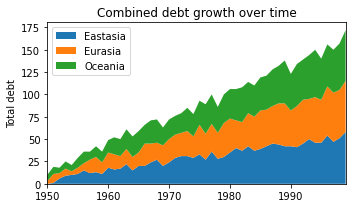

In [16]:
rng = np.arange(50)
rnd = np.random.randint(0, 10, size=(3, rng.size))
yrs = 1950 + rng

fig, ax = plt.subplots(figsize=(5, 3))
ax.stackplot(yrs, rng + rnd, labels=['Eastasia', 'Eurasia', 'Oceania'])
ax.set_title('Combined debt growth over time')
ax.legend(loc='upper left')
ax.set_ylabel('Total debt')
ax.set_xlim(xmin=yrs[0], xmax=yrs[-1])
fig.tight_layout()